## Lab Objective

In this lab, you will explore whether you can differentiate photos taken by different people. Specifically, you’ll work with pictures taken by **Dr. Alex Dekhtyar**, **Dr. Kelly Bodwin**, or your instructor. You’ll use two machine learning approaches to determine the likely photographer for 20 unknown test images.

## Dataset Information

The dataset contains:

* Approximately **100 images taken by Alex**
* Approximately **100 images taken by Kelly**
* **20 test images** taken by **Alex, Kelly, or the instructor**

> **Note:** These images are not formatted like MNIST, so you’ll need to research how to import and process them in Python.

## Primary Goal

Your task is to identify the photographer of the 20 test images using **two distinct approaches**.

## Approach 1: Feature-Based Classification

1. Train individual (convolutional) neural networks for the following image features:

   * Presence of a **human**
   * Presence of a **castle**
   * Whether the image is taken **indoors or outdoors**
   * The **landscape type** (e.g., city, suburb, nature/rural)

2. Develop at least **10 additional features** (or feature categories) that may help distinguish between Alex's and Kelly's photos. For each, train a separate (convolutional) neural network.

3. Treat the outputs of all 14+ feature models as inputs to a final **classification model** that predicts the photographer (**Alex** or **Kelly**).

   * This final model does **not** have to be a neural network.

## Loading Image Data

The example code below was developed with guidance and inspiration from the following resources:

* [YouTube Tutorial – Image Classification with TensorFlow](https://www.youtube.com/watch?v=uqomO_BZ44g)
* [Stack Overflow – ImportError with `ImageDataGenerator`](https://stackoverflow.com/questions/78145837/importerror-cannot-import-name-imagedatagenerator-from-keras-preprocessing-i)
* [TensorFlow Documentation – `image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)


In [24]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, applications, regularizers
from sklearn.utils import class_weight


# Set Constant Image Size
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
SEED = 42

import random

def set_global_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [25]:
# Paths
train_dir = "Alex_Kelly_Pics/train"
test_dir = "Alex_Kelly_Pics/test"

# Load training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Load test dataset (unlabeled)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels=None,
    shuffle=False,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1
)

Found 715 files belonging to 3 classes.
Using 572 files for training.
Found 715 files belonging to 3 classes.
Using 143 files for validation.
Found 20 files.


### Example Images

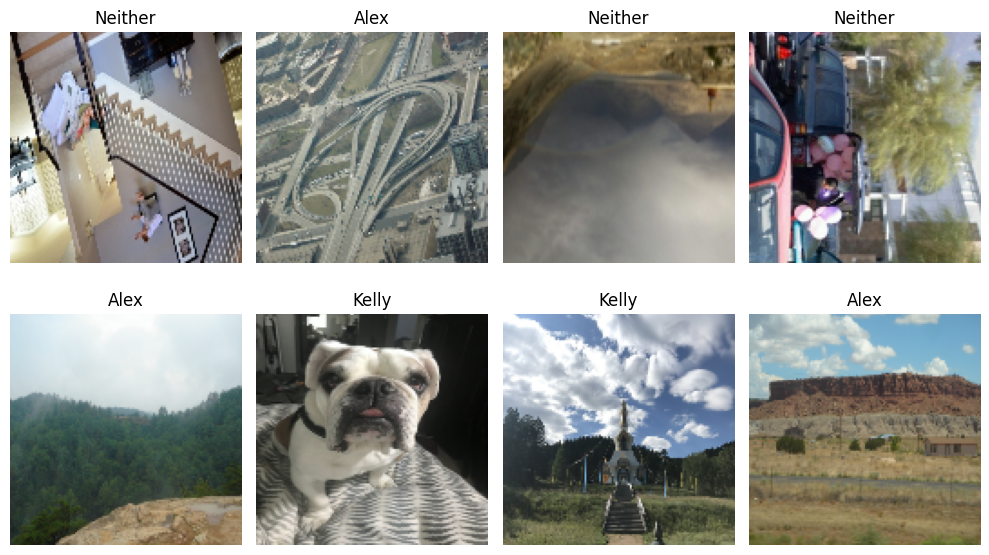

In [26]:
def visualize_batch(dataset, class_names):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(8):
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[np.argmax(labels[i].numpy())])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_batch(train_ds, class_names=["Alex", "Kelly", "Neither"])

### Normalize and Optimize Datasets

To prepare our images for training, we normalize the pixel values using tf.keras.layers.Rescaling(1./255). This layer scales the original RGB values from the range [0, 255] down to [0, 1], which is a standard practice in deep learning. Normalization helps the model train more efficiently by stabilizing gradients, improving convergence, and ensuring that inputs are on a consistent scale, especially important when using activation functions like ReLU or Sigmoid.

In [27]:
# Normalize images to [0, 1] range
normalization_layer = tf.keras.layers.Rescaling(1. / 255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x: normalization_layer(x)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Approach 1: Feature Detection

In [28]:
def train_feature_cnn(feature_dir, img_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=32, epochs=20):
    train_path = os.path.join(feature_dir, "train")
    # Load unbatched dataset to extract class distribution
    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        train_path,
        image_size=img_size,
        batch_size=None,  # unbatched for label extraction
        validation_split=0.2,
        subset="training",
        seed=42,
        label_mode="binary"
    )

    # Extract labels to compute class weights
    label_list = [int(y.numpy()) for _, y in raw_train_ds]
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(label_list),
        y=label_list
    )
    class_weights_dict = dict(enumerate(class_weights))

    # Load batched training and validation datasets
    train_ds = raw_train_ds.batch(batch_size)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        train_path,
        image_size=img_size,
        batch_size=batch_size,
        validation_split=0.2,
        subset="validation",
        seed=SEED,
        label_mode="binary"
    )

    # Data augmentation for training set
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ])
    rescale = layers.Rescaling(1./255)

    train_ds = train_ds.map(lambda x, y: (data_augmentation(rescale(x)), y)).cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (rescale(x), y)).cache().prefetch(tf.data.AUTOTUNE)

    # CNN model
    model = models.Sequential([
        tf.keras.Input(shape=img_size + (3,)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train with class weights
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop],
        class_weight=class_weights_dict
    )

    return model, history

### Human Detection

In [29]:
human_model, human_history = train_feature_cnn("Human_Pics", epochs=100)

Found 890 files belonging to 2 classes.
Using 712 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 890 files belonging to 2 classes.
Using 178 files for validation.
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.4764 - loss: 0.7500 - val_accuracy: 0.6124 - val_loss: 0.6867
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.5126 - loss: 0.6816 - val_accuracy: 0.6180 - val_loss: 0.6734
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.5880 - loss: 0.6597 - val_accuracy: 0.6236 - val_loss: 0.7147
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.6295 - loss: 0.6302 - val_accuracy: 0.6348 - val_loss: 0.7257
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7079 - loss: 0.5897 - val_accuracy: 0.5787 - val_loss: 0.9422
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7462 - loss: 0.5428 - val_accuracy: 0.6236 - val_loss: 0.6471
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.6886 - loss: 0.5834 - val_accuracy: 0.6348 - val_loss: 0.6592
Epoch 8/100
23/23 ━━━━━━━━━━━━━

### Castle Detection

In [30]:
castle_model, castle_history = train_feature_cnn("Castle_Pics", epochs = 100)

Found 1424 files belonging to 2 classes.
Using 1140 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 1424 files belonging to 2 classes.
Using 284 files for validation.
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.5942 - loss: 0.7040 - val_accuracy: 0.8662 - val_loss: 0.3695
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8392 - loss: 0.4024 - val_accuracy: 0.8803 - val_loss: 0.3163
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8345 - loss: 0.3774 - val_accuracy: 0.8627 - val_loss: 0.3326
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8709 - loss: 0.3113 - val_accuracy: 0.8556 - val_loss: 0.3526
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8728 - loss: 0.2809 - val_accuracy: 0.8592 - val_loss: 0.3555
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8877 - loss: 0.2548 - val_accuracy: 0.8768 - val_loss: 0.3936
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8855 - loss: 0.2455 - val_accuracy: 0.8732 - val_loss: 0.3919


### Food Detection

In [31]:
food_model, food_history = train_feature_cnn("Food_Pics")

530/530 ━━━━━━━━━━━━━━━━━━━━ 37s 70ms/step - accuracy: 0.9346 - loss: 0.1501 - val_accuracy: 0.9252 - val_loss: 0.1930


### Indoor / Outdoor Detecttion

In [32]:
indoor_outdoor_model, indoor_outdoor_history = train_feature_cnn("Indoor_Outdoor_Pics")

Found 770 files belonging to 2 classes.
Using 616 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 770 files belonging to 2 classes.
Using 154 files for validation.
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.5443 - loss: 0.7261 - val_accuracy: 0.7727 - val_loss: 0.5112
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7761 - loss: 0.5137 - val_accuracy: 0.7727 - val_loss: 0.4770
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7638 - loss: 0.4707 - val_accuracy: 0.7468 - val_loss: 0.4806
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8134 - loss: 0.4270 - val_accuracy: 0.7338 - val_loss: 0.5794
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8500 - loss: 0.3721 - val_accuracy: 0.7662 - val_loss: 0.5759
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8790 - loss: 0.3441 - val_accuracy: 0.7922 - val_loss: 0.5111
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8664 - loss: 0.3207 - val_accuracy: 0.6623 - val_loss: 0.9277


### Pet Detection

In [33]:
pet_model, pet_history = train_feature_cnn("Pet_Pics")

469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - accuracy: 0.8849 - loss: 0.2771 - val_accuracy: 0.7821 - val_loss: 0.6213


### Vehicle Detection

In [34]:
vehicle_model, vehicle_history = train_feature_cnn("Vehicle_Pics")

444/444 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9845 - loss: 0.0428 - val_accuracy: 0.9921 - val_loss: 0.0234
Epoch 8/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.9925 - loss: 0.0208 - val_accuracy: 0.9890 - val_loss: 0.0391
Epoch 9/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9929 - loss: 0.0242 - val_accuracy: 0.9901 - val_loss: 0.0297
Epoch 10/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9923 - loss: 0.0240 - val_accuracy: 0.9927 - val_loss: 0.0254


### Flower Detection

In [35]:
flower_model, flower_history = train_feature_cnn("Flower_Pics")

Found 1367 files belonging to 2 classes.
Using 1094 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 1367 files belonging to 2 classes.
Using 273 files for validation.
Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.5404 - loss: 0.7430 - val_accuracy: 0.5531 - val_loss: 1.1912
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8130 - loss: 0.5208 - val_accuracy: 0.8974 - val_loss: 0.2875
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9113 - loss: 0.2514 - val_accuracy: 0.8938 - val_loss: 0.3370
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9287 - loss: 0.2010 - val_accuracy: 0.9121 - val_loss: 0.2000
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9315 - loss: 0.1572 - val_accuracy: 0.9158 - val_loss: 0.2380
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9549 - loss: 0.1181 - val_accuracy: 0.9231 - val_loss: 0.2204
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9612 - loss: 0.1225 - val_accuracy: 0.9231 - val_loss: 0.2037
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━

### Forest Detection

In [36]:
forest_model, forest_history = train_feature_cnn("Forest_Pics")

Found 3997 files belonging to 2 classes.
Using 3198 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 3997 files belonging to 2 classes.
Using 799 files for validation.
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.7626 - loss: 0.4859 - val_accuracy: 0.9199 - val_loss: 0.2509
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.9221 - loss: 0.2060 - val_accuracy: 0.9524 - val_loss: 0.1206
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9521 - loss: 0.1401 - val_accuracy: 0.9599 - val_loss: 0.1129
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.9531 - loss: 0.1308 - val_accuracy: 0.9612 - val_loss: 0.1002
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9693 - loss: 0.0959 - val_accuracy: 0.9587 - val_loss: 0.1238
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9774 - loss: 0.0787 - val_accuracy: 0.9549 - val_loss: 0.1448
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9850 - loss: 0.0626 - val_accuracy: 0.9349 - val_loss: 0.2072
Epoch 8/20
100/100 ━

### Glacier Detection

In [37]:
glacier_model, glacier_history = train_feature_cnn("Glacier_Pics")

Found 4198 files belonging to 2 classes.
Using 3359 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 4198 files belonging to 2 classes.
Using 839 files for validation.
Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.7458 - loss: 0.5487 - val_accuracy: 0.9094 - val_loss: 0.2743
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.9158 - loss: 0.2683 - val_accuracy: 0.9201 - val_loss: 0.2247
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9128 - loss: 0.2363 - val_accuracy: 0.9297 - val_loss: 0.2114
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9198 - loss: 0.2138 - val_accuracy: 0.9285 - val_loss: 0.1978
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.9163 - loss: 0.2070 - val_accuracy: 0.9297 - val_loss: 0.2011
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.9363 - loss: 0.1839 - val_accuracy: 0.9261 - val_loss: 0.2132
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.9448 - loss: 0.1516 - val_accuracy: 0.9201 - val_loss: 0.2331
Epoch 8/20
10

### Mountain Detection

In [38]:
mountain_model, mountain_history = train_feature_cnn("Mountain_Pics")

Found 4198 files belonging to 2 classes.
Using 3359 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 4198 files belonging to 2 classes.
Using 839 files for validation.
Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.7500 - loss: 0.5183 - val_accuracy: 0.8689 - val_loss: 0.3225
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.8666 - loss: 0.3574 - val_accuracy: 0.8999 - val_loss: 0.2795
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.8536 - loss: 0.3743 - val_accuracy: 0.8987 - val_loss: 0.2642
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.8881 - loss: 0.3020 - val_accuracy: 0.8951 - val_loss: 0.2689
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.8876 - loss: 0.2921 - val_accuracy: 0.9023 - val_loss: 0.2682
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9022 - loss: 0.2668 - val_accuracy: 0.9023 - val_loss: 0.2587
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9154 - loss: 0.2211 - val_accuracy: 0.9106 - val_loss: 0.2567
Epoch 8/20
105/1

### Ocean/Sea Detection

In [39]:
sea_model, sea_history = train_feature_cnn("Sea_Pics")

Found 3823 files belonging to 2 classes.
Using 3059 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 3823 files belonging to 2 classes.
Using 764 files for validation.
Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.7415 - loss: 0.5101 - val_accuracy: 0.7788 - val_loss: 0.5158
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.8803 - loss: 0.3102 - val_accuracy: 0.8783 - val_loss: 0.3075
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.8904 - loss: 0.2667 - val_accuracy: 0.8743 - val_loss: 0.2983
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.9016 - loss: 0.2355 - val_accuracy: 0.9149 - val_loss: 0.2231
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9301 - loss: 0.1947 - val_accuracy: 0.8940 - val_loss: 0.2547
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9380 - loss: 0.1686 - val_accuracy: 0.8992 - val_loss: 0.3011
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.9407 - loss: 0.1636 - val_accuracy: 0.9110 - val_loss: 0.2770
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━

### Street Detection

In [40]:
street_model, street_history = train_feature_cnn("Street_Pics")

Found 4163 files belonging to 2 classes.
Using 3331 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 4163 files belonging to 2 classes.
Using 832 files for validation.
Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step - accuracy: 0.6628 - loss: 0.5792 - val_accuracy: 0.9075 - val_loss: 0.2265
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.8931 - loss: 0.2931 - val_accuracy: 0.9087 - val_loss: 0.2364
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9016 - loss: 0.2770 - val_accuracy: 0.9183 - val_loss: 0.1992
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.9098 - loss: 0.2557 - val_accuracy: 0.9243 - val_loss: 0.1869
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9212 - loss: 0.2227 - val_accuracy: 0.9339 - val_loss: 0.1684
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.9256 - loss: 0.1998 - val_accuracy: 0.9291 - val_loss: 0.1833
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.9274 - loss: 0.1891 - val_accuracy: 0.9303 - val_loss: 0.1698
Epoch 8/20
105/

### Day/Night Classification

In [41]:
daynight_model, daynight_history = train_feature_cnn("DayNight_Pics")

Found 240 files belonging to 2 classes.
Using 192 files for training.
Found 240 files belonging to 2 classes.
Using 48 files for validation.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.5578 - loss: 0.6264 - val_accuracy: 0.8125 - val_loss: 0.4112
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8689 - loss: 0.2967 - val_accuracy: 0.8542 - val_loss: 0.3707
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9965 - loss: 0.0414 - val_accuracy: 0.9583 - val_loss: 0.0917
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9782 - loss: 0.0842 - val_accuracy: 1.0000 - val_loss: 0.0228
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9416 - loss: 0.1860 - val_accuracy: 1.0000 - val_loss: 0.0080
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9619 - loss: 0.0715 - val_accuracy: 1.0000 - val_loss: 0.0368
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.9704 - loss: 0.0905 - val_accuracy: 0.9792 - val_loss: 0.1263
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9834 - loss: 0.0578 - val_accuracy: 0.9792 - val_loss: 0.

### Final Predictive Model

In [42]:
def extract_feature_predictions(image_dir, model_dict, img_size=(128, 128)):
    data = []
    labels = []
    filenames = []

    class_folders = ["Alex", "Kelly"]
    label_map = {"Alex": 0, "Kelly": 1}

    for class_name in class_folders:
        class_path = os.path.join(image_dir, class_name)
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, fname)
                img = image.load_img(img_path, target_size=img_size)
                img_array = image.img_to_array(img) / 255.0
                img_array = np.expand_dims(img_array, axis=0)

                row = []
                for feature_name, model in model_dict.items():
                    pred = model.predict(img_array, verbose=0)[0][0]  # Sigmoid output
                    row.append(pred)

                data.append(row)
                labels.append(label_map[class_name])
                filenames.append(fname)

    return np.array(data), np.array(labels), filenames

In [43]:
model_dict = {
    "human": human_model,
    "castle": castle_model,
    "flower": flower_model,
    "vehicle": vehicle_model,
    "pet": pet_model,
    "indoor_outdoor": indoor_outdoor_model,
    "forest": forest_model,
    "glacier": glacier_model,
    "mountain": mountain_model,
    "sea": sea_model,
    "street": street_model,
    "daynight": daynight_model,
}

X, y, filenames = extract_feature_predictions("Alex_Kelly_Pics/train", model_dict)

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=["Alex", "Kelly"]))

Validation Accuracy: 0.7525773195876289
              precision    recall  f1-score   support

        Alex       0.76      0.76      0.76        51
       Kelly       0.74      0.74      0.74        46

    accuracy                           0.75        97
   macro avg       0.75      0.75      0.75        97
weighted avg       0.75      0.75      0.75        97



In [49]:
def predict_test_images(test_dir, model_dict, final_classifier, threshold=0.6, img_size=(128, 128)):
    results = []

    for fname in sorted(os.listdir(test_dir)):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(test_dir, fname)
            img = image.load_img(img_path, target_size=img_size)
            img_array = image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            feature_row = []
            for _, model in model_dict.items():
                pred = model.predict(img_array, verbose=0)[0][0]
                feature_row.append(pred)

            feature_row = np.array(feature_row).reshape(1, -1)
            proba = final_classifier.predict_proba(feature_row)[0]
            predicted_idx = np.argmax(proba)

            if max(proba) < threshold:
                predicted_label = "Neither"
            else:
                predicted_label = "Alex" if predicted_idx == 0 else "Kelly"

            results.append((fname, predicted_label, round(max(proba), 2)))

    return results

### Run Final Predictions

In [51]:
test_results = predict_test_images("Alex_Kelly_Pics/test/TestSet", model_dict, clf)

for fname, pred, conf in test_results:
    print(f"{fname}: {pred} ({conf})")

TestSetImage01.png: Alex (0.69)
TestSetImage02.png: Neither (0.56)
TestSetImage03.png: Kelly (0.77)
TestSetImage04.png: Kelly (0.73)
TestSetImage05.png: Alex (0.69)
TestSetImage06.png: Kelly (0.67)
TestSetImage07.png: Neither (0.55)
TestSetImage08.png: Kelly (0.81)
TestSetImage09.png: Kelly (0.67)
TestSetImage10.png: Kelly (0.76)
TestSetImage11.png: Alex (0.74)
TestSetImage12.png: Neither (0.51)
TestSetImage13.png: Kelly (0.81)
TestSetImage14.png: Kelly (0.71)
TestSetImage15.png: Alex (0.66)
TestSetImage16.png: Neither (0.51)
TestSetImage17.png: Neither (0.57)
TestSetImage18.png: Neither (0.53)
TestSetImage19.png: Alex (0.6)
TestSetImage20.png: Kelly (0.88)


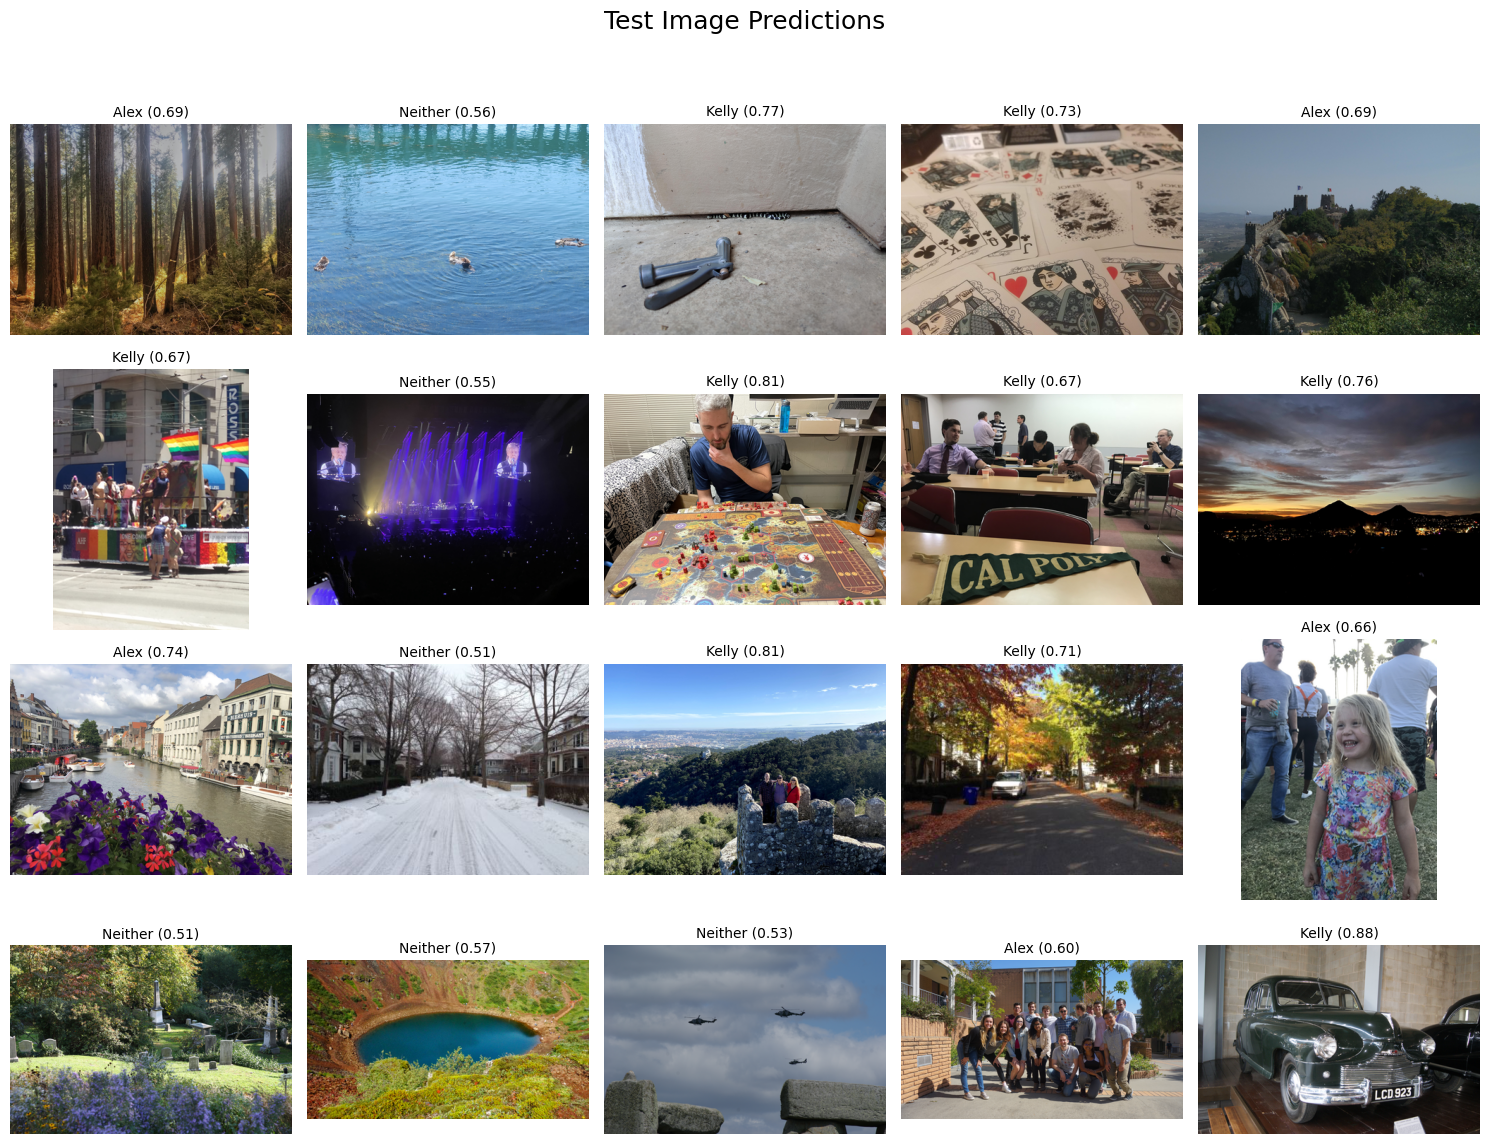

In [54]:
from PIL import Image
# Folder where your test images are stored
test_image_dir = "Alex_Kelly_Pics/test/TestSet"  # Adjust if needed

# Plotting
n_images = len(test_results)
n_cols = 5
n_rows = (n_images + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
fig.suptitle("Test Image Predictions", fontsize=18)


for ax, (filename, pred, conf) in zip(axes.flatten(), test_results):
    image_path = os.path.join(test_image_dir, filename)
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"{pred} ({conf:.2f})", fontsize=10)

# Hide any empty subplots
for i in range(len(test_results), n_rows * n_cols):
    axes.flatten()[i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Approach 2: Direct Classification

Train a **convolutional neural network** to directly classify the images as being taken by **Alex** or **Kelly**.

## Assignment Specifications

* Work in a group of **3 students**.
* You are **not allowed to use image metadata**.
* Your final deliverable must:

  * Identify your **best-performing model/approach**.
  * Include your **predictions for all 20 test images**: Alex, Kelly, or Neither.
* The training set contains only two photographers. Because your final predictions involve three classes, you **may use external data** to improve your models.

  * Any external data must be **legal, ethical, and documented** clearly.
* Your notebook should be **narrated for a non-expert audience**.

* Include all code, but explain your steps in accessible, beginner-friendly language.


## Approach 2: CNN 

To prevent overfitting and ensure generalization, we used early stopping with restore_best_weights=True. This allowed the model to automatically revert to the epoch that achieved the lowest validation loss. As a result, our final model reflects the best performance observed during training.

We begin by setting a **seed value**. This is a technical step that ensures the results of our model are reproducible. Without setting this seed, we might get slightly different outcomes every time we run the model, which can make comparisons difficult. By fixing the seed for TensorFlow, NumPy, and Python’s random number generators, we create a consistent starting point for training.

Next, we load in our image data from folders using a TensorFlow utility. Each image is automatically labeled based on the folder it’s in — such as "Alex" or "Kelly." We split this data into a **training set** and a **validation set** using an 80/20 ratio. Before training, we calculate **class weights** to handle any imbalance — for instance, if there are more photos of Kelly than Alex, the model might start favoring one class. We correct for that imbalance so it doesn’t skew the predictions.

Once the class weights are ready, we reload the images and apply **preprocessing**. First, we rescale the image pixel values to fall between 0 and 1 instead of the original 0 to 255. This helps the model train more smoothly. We also add **image augmentation**, which slightly changes the training images by flipping them, rotating them, or zooming in. These small random changes simulate real-world variety and help the model become more generalizable, rather than memorizing specific images.

For our actual model, we use **MobileNetV2**, a pre-trained CNN that has already been trained on millions of images. We load this model without its final classification layers so that we can add our own custom layers for our task. We also freeze the pre-trained layers so that their learned features are preserved — we don’t want to accidentally unlearn what the model already knows. On top of MobileNetV2, we add new layers: one that condenses the image data, another that helps prevent overfitting (called a dropout layer), and finally two layers that perform the classification — ending with a **softmax layer** that assigns a probability to each class (Alex, Kelly, or Neither).

The model is compiled using the **Adam optimizer**, which is widely used because it adapts the learning rate during training. We use **sparse categorical crossentropy** as the loss function, which is appropriate when you’re predicting one of several possible categories. We also monitor accuracy during training. To avoid training for too long and overfitting the data, we include an **early stopping** mechanism. This watches the validation performance and stops training if things stop improving.In the end, this function returns the trained model and a record of the training process, so we can later visualize how performance changed over time. 

In [44]:
# Set seeds for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

def train_alex_kelly_classifier_transfer(data_dir="Alex_Kelly_Pics/train", img_size=(128, 128), batch_size=32, epochs=30):
    # Step 1: Load raw dataset for class weight calculation (use int labels)
    raw_label_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=SEED,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int"
    )

    y_train_int = []
    for _, labels in raw_label_ds:
        y_train_int.extend(labels.numpy())
    y_train_int = np.array(y_train_int)

    class_weights = dict(enumerate(class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_int),
        y=y_train_int
    )))

    # Step 2: Load datasets again for model training (same int labels)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int"
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int"
    )

    # Step 3: Normalize and augment
    rescale = layers.Rescaling(1./255)
    augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ])

    train_ds = train_ds.map(lambda x, y: (augmentation(rescale(x)), y)).cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (rescale(x), y)).cache().prefetch(tf.data.AUTOTUNE)

    # Step 4: Define transfer learning model
    base_model = applications.MobileNetV2(input_shape=img_size + (3,),
                                          include_top=False,
                                          weights="imagenet")
    base_model.trainable = False  # Freeze base

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dense(3, activation='softmax')  # 3 classes: Alex, Kelly, Neither
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Step 5: Train with early stopping and class weights
    early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(train_ds, validation_data=val_ds,
                        epochs=epochs,
                        class_weight=class_weights,
                        callbacks=[early_stop])

    return model, history

In [45]:
model, history = train_alex_kelly_classifier_transfer()

Found 715 files belonging to 3 classes.
Using 572 files for training.
Found 715 files belonging to 3 classes.
Using 572 files for training.
Found 715 files belonging to 3 classes.
Using 143 files for validation.
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 332ms/step - accuracy: 0.3909 - loss: 2.8884 - val_accuracy: 0.5874 - val_loss: 2.0407
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.6085 - loss: 1.9375 - val_accuracy: 0.7483 - val_loss: 1.7938
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.7181 - loss: 1.7411 - val_accuracy: 0.7552 - val_loss: 1.6054
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.7780 - loss: 1.5105 - val_accuracy: 0.7622 - val_loss: 1.4773
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.8057 - loss: 1.3489 - val_accuracy: 0.7483 - val_loss: 1.4210
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.7876 - loss: 1.2734 - val_accuracy: 0.7552 - val_loss: 1.2917
Epoch 7/30
18/18 ━━

In [46]:
from tensorflow.keras.preprocessing import image
def predict_and_visualize_thresholded(model, test_dir, class_names, img_size=(128, 128), threshold=0.6, max_images=20):
    image_files = sorted([
        f for f in os.listdir(test_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])[:max_images]

    plt.figure(figsize=(15, 8))

    for i, fname in enumerate(image_files):
        img_path = os.path.join(test_dir, fname)
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array, verbose=0)[0]
        predicted_idx = np.argmax(prediction)
        confidence = prediction[predicted_idx]

        if confidence < threshold:
            predicted_label = "Neither"
        else:
            predicted_label = class_names[predicted_idx]

        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{predicted_label}\n({confidence:.2f})", fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

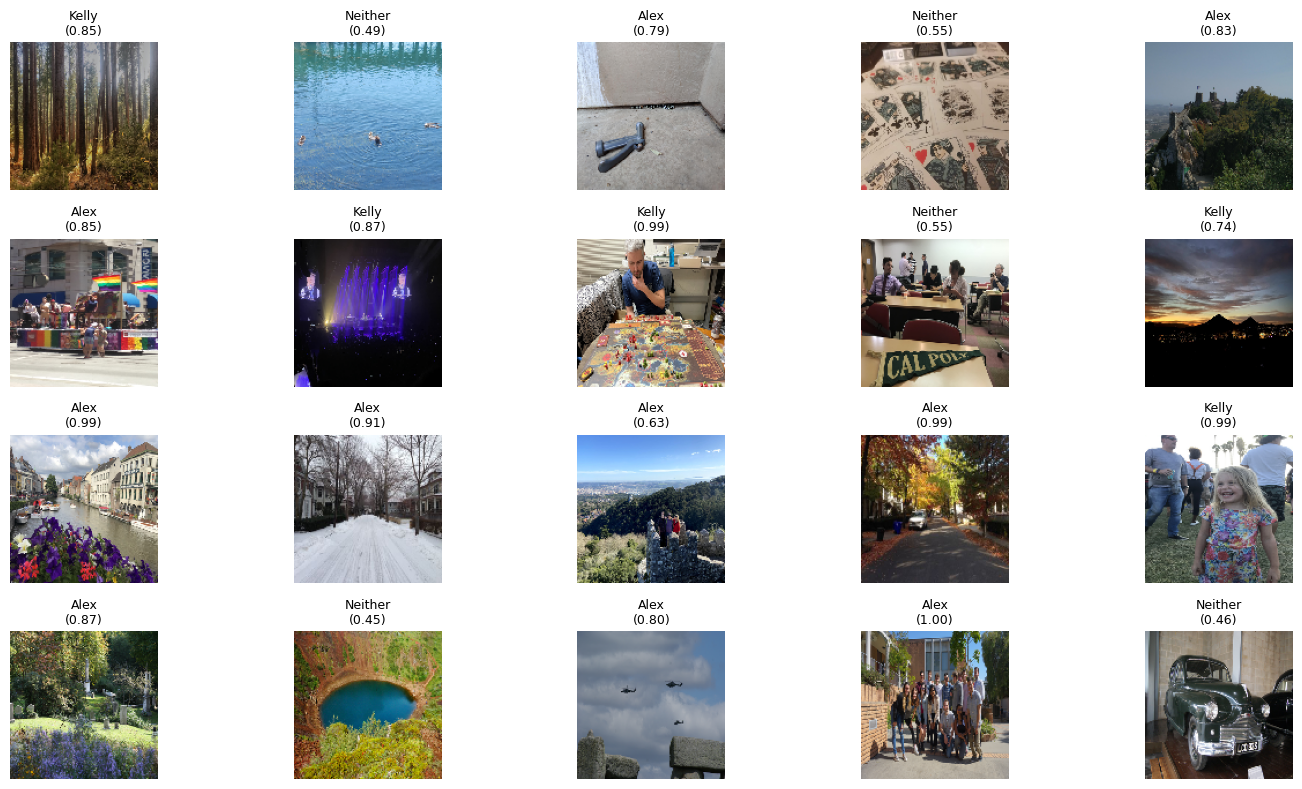

In [47]:
test_dir = "Alex_Kelly_Pics/test/TestSet"
class_names = ["Alex", "Kelly", "Neither"]
predict_and_visualize_thresholded(model, test_dir, class_names)